In [22]:
# Test cell to verify notebook is working
print("🔧 Testing Jupyter notebook environment...")
import sys
import os
print(f"Python version: {sys.version}")
print(f"Current working directory: {os.getcwd()}")
print(f"Python path: {sys.path[0] if sys.path else 'Unknown'}")

# Test basic imports
try:
    import pandas as pd
    import numpy as np
    print("✅ Basic data science libraries available")
except ImportError as e:
    print(f"❌ Import error: {e}")

# Test directory structure
from pathlib import Path
base_dir = Path(os.getcwd())
print(f"📁 Base directory: {base_dir}")
print(f"📂 Directory contents: {list(base_dir.iterdir())[:10]}")  # Show first 10 items

print("🚀 Notebook is ready to run!")


🔧 Testing Jupyter notebook environment...
Python version: 3.13.2 (v3.13.2:4f8bb3947cf, Feb  4 2025, 11:51:10) [Clang 15.0.0 (clang-1500.3.9.4)]
Current working directory: /Users/punnoosekthomas/Documents/Hobby Projects/marine-debris-classification
Python path: /Library/Frameworks/Python.framework/Versions/3.13/lib/python313.zip
✅ Basic data science libraries available
📁 Base directory: /Users/punnoosekthomas/Documents/Hobby Projects/marine-debris-classification
📂 Directory contents: [PosixPath('/Users/punnoosekthomas/Documents/Hobby Projects/marine-debris-classification/marine-debris-env'), PosixPath('/Users/punnoosekthomas/Documents/Hobby Projects/marine-debris-classification/setup.sh'), PosixPath('/Users/punnoosekthomas/Documents/Hobby Projects/marine-debris-classification/.DS_Store'), PosixPath('/Users/punnoosekthomas/Documents/Hobby Projects/marine-debris-classification/config.py'), PosixPath('/Users/punnoosekthomas/Documents/Hobby Projects/marine-debris-classification/LICENSE'), P


# Marine Debris Source Classification Project
===========================================

Comprehensive analysis and classification of marine debris using NASA/NOAA dataset.
This script covers data preprocessing, feature engineering, machine learning models,
geospatial analysis, and visualization.

Author: Marine Debris Classification Team

Date: June 2025

## IMPORTS AND SETUP

In [23]:
import warnings
warnings.filterwarnings('ignore')

In [24]:
# Standard library imports
import os
import sys
import logging
from pathlib import Path
from datetime import datetime
from typing import Dict, List, Tuple, Optional, Any

In [25]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm

In [26]:
# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import folium
from folium.plugins import HeatMap, MarkerCluster

In [27]:
# Machine learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                           precision_score, recall_score, f1_score, roc_auc_score,
                           roc_curve, precision_recall_curve)
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif

In [28]:
# Optional libraries - handle gracefully if not available
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    print("Warning: XGBoost not available. XGBoost models will be skipped.")
    XGBOOST_AVAILABLE = False

try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
    TENSORFLOW_AVAILABLE = True
except ImportError:
    print("Warning: TensorFlow not available. Neural network models will be skipped.")
    TENSORFLOW_AVAILABLE = False

try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    print("Warning: SHAP not available. SHAP analysis will be skipped.")
    SHAP_AVAILABLE = False

try:
    import lime
    from lime.lime_tabular import LimeTabularExplainer
    LIME_AVAILABLE = True
except ImportError:
    print("Warning: LIME not available. LIME analysis will be skipped.")
    LIME_AVAILABLE = False

In [29]:
# Geospatial analysis
import geopandas as gpd

In [30]:
# Clustering and dimensionality reduction
import umap

In [31]:
# Utilities
from tqdm import tqdm
import joblib
import pickle
from collections import Counter
import json

In [32]:
# Kaggle API
try:
    import kaggle
    KAGGLE_AVAILABLE = True
except (ImportError, OSError) as e:
    KAGGLE_AVAILABLE = False
    if "kaggle.json" in str(e):
        print("Warning: Kaggle API credentials not configured. Sample data will be used instead.")
    else:
        print("Warning: Kaggle API not available. Please install with: pip install kaggle")

In [33]:
# Configuration for Jupyter Notebook Environment
try:
    import config
    # Import all configuration variables into global namespace
    for name in dir(config):
        if not name.startswith('_'):
            globals()[name] = getattr(config, name)
    print("✅ Configuration loaded successfully")
except ImportError:
    print("❌ Config file not found. Using default settings.")
    
    # Fixed configuration for Jupyter notebooks
    import os
    BASE_DIR = Path(os.getcwd())  # Use current working directory for notebooks
    DATA_DIR = BASE_DIR / "data"
    RAW_DATA_DIR = DATA_DIR / "raw"
    PROCESSED_DATA_DIR = DATA_DIR / "processed"
    MODELS_DIR = BASE_DIR / "models"
    TRAINED_MODELS_DIR = MODELS_DIR / "trained"
    RESULTS_DIR = BASE_DIR / "results"
    FIGURES_DIR = RESULTS_DIR / "figures"
    VISUALIZATIONS_DIR = BASE_DIR / "visualizations"
    REPORTS_DIR = BASE_DIR / "reports"
    
    # Create directories
    for directory in [DATA_DIR, RAW_DATA_DIR, PROCESSED_DATA_DIR, MODELS_DIR, 
                      TRAINED_MODELS_DIR, RESULTS_DIR, FIGURES_DIR, VISUALIZATIONS_DIR, REPORTS_DIR]:
        directory.mkdir(parents=True, exist_ok=True)
    
    DATASET_CONFIG = {
        'raw_data_file': 'nasaa.csv',
        'test_size': 0.2,
        'random_state': 42
    }
    
    print(f"📁 Working directory: {BASE_DIR}")
    print(f"📊 Data directory: {DATA_DIR}")
    print(f"📈 Results directory: {RESULTS_DIR}")
    print("🏗️ Directory structure created successfully")

✅ Configuration loaded successfully


## LOGGING SETUP

In [34]:
def setup_logging():
    """Setup logging configuration."""
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
        handlers=[
            logging.FileHandler(RESULTS_DIR / 'marine_debris_analysis.log'),
            logging.StreamHandler()
        ]
    )
    return logging.getLogger(__name__)

logger = setup_logging()

## DATA LOADING AND PREPROCESSING

In [35]:
class MarineDebrisDataLoader:
    """Handle data loading and initial preprocessing."""
    
    def __init__(self, config: Dict[str, Any]):
        self.config = config
        self.raw_data = None
        self.processed_data = None
        
    def download_data_from_kaggle(self, dataset_name: str) -> bool:
        """Download dataset from Kaggle."""
        if not KAGGLE_AVAILABLE:
            logger.error("Kaggle API not available")
            return False
            
        try:
            logger.info(f"Downloading dataset: {dataset_name}")
            kaggle.api.dataset_download_files(
                dataset_name,
                path=str(RAW_DATA_DIR),
                unzip=True
            )
            logger.info("Dataset downloaded successfully")
            return True
        except Exception as e:
            logger.error(f"Error downloading dataset: {e}")
            return False
    
    def load_raw_data(self, file_path: Optional[str] = None) -> pd.DataFrame:
        """Load raw data from CSV file."""
        if file_path is None:
            file_path = RAW_DATA_DIR / self.config['raw_data_file']
        
        try:
            logger.info(f"Loading data from: {file_path}")
            self.raw_data = pd.read_csv(file_path)
            logger.info(f"Data loaded successfully. Shape: {self.raw_data.shape}")
            return self.raw_data
        except FileNotFoundError:
            logger.error(f"Data file not found: {file_path}")
            # Create sample data for demonstration
            return self._create_sample_data()
        except Exception as e:
            logger.error(f"Error loading data: {e}")
            return self._create_sample_data()
    
    def _create_sample_data(self) -> pd.DataFrame:
        """Create sample marine debris data for demonstration."""
        logger.info("Creating sample marine debris data...")
        
        np.random.seed(42)
        n_samples = 10000
        
        # Generate sample data
        data = {
            'Country': np.random.choice(['USA', 'Canada', 'Mexico', 'UK', 'Australia'], n_samples),
            'State': np.random.choice(['CA', 'FL', 'TX', 'NY', 'WA', 'OR', 'NC', 'SC'], n_samples),
            'Latitude': np.random.uniform(25, 48, n_samples),
            'Longitude': np.random.uniform(-125, -70, n_samples),
            'Date': pd.date_range('2015-01-01', '2023-12-31', periods=n_samples),
            'Season': np.random.choice(['Spring', 'Summer', 'Fall', 'Winter'], n_samples),
            'Weather': np.random.choice(['Sunny', 'Cloudy', 'Rainy', 'Windy'], n_samples),
            'Storm_Activity': np.random.choice(['None', 'Low', 'Medium', 'High'], n_samples),
            'Slope': np.random.uniform(0, 45, n_samples),
            'Width': np.random.uniform(10, 500, n_samples),
            'Length': np.random.uniform(100, 5000, n_samples),
            'Plastic_Bags': np.random.poisson(5, n_samples),
            'Plastic_Bottles': np.random.poisson(8, n_samples),
            'Plastic_Food_Containers': np.random.poisson(3, n_samples),
            'Metal_Cans': np.random.poisson(4, n_samples),
            'Glass_Bottles': np.random.poisson(2, n_samples),
            'Rubber_Gloves': np.random.poisson(1, n_samples),
            'Cloth_Items': np.random.poisson(2, n_samples),
            'Organization': np.random.choice(['Ocean Conservancy', 'Surfrider', 'Local Groups'], n_samples),
            'Shoreline_Name': [f'Beach_{i%100}' for i in range(n_samples)]
        }
        
        df = pd.DataFrame(data)
        df['Survey_Year'] = df['Date'].dt.year
        
        # Save sample data
        sample_file = RAW_DATA_DIR / 'sample_marine_debris.csv'
        df.to_csv(sample_file, index=False)
        logger.info(f"Sample data created and saved to: {sample_file}")
        
        self.raw_data = df
        return df

In [36]:
class MarineDebrisPreprocessor:
    """Handle data preprocessing and feature engineering."""
    
    def __init__(self, data: pd.DataFrame):
        self.data = data.copy()
        self.processed_data = None
        self.feature_columns = []
        self.target_columns = []
        self.encoders = {}
        self.scalers = {}
        
    def basic_preprocessing(self) -> pd.DataFrame:
        """Perform basic data preprocessing."""
        logger.info("Starting basic preprocessing...")
        
        df = self.data.copy()
        
        # Handle missing values
        df = self._handle_missing_values(df)
        
        # Data type conversions
        df = self._convert_data_types(df)
        
        # Remove outliers
        df = self._remove_outliers(df)
        
        logger.info(f"Basic preprocessing completed. Shape: {df.shape}")
        return df
    
    def _handle_missing_values(self, df: pd.DataFrame) -> pd.DataFrame:
        """Handle missing values in the dataset."""
        logger.info("Handling missing values...")
        
        # Numeric columns - fill with median
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            if df[col].isnull().sum() > 0:
                df[col].fillna(df[col].median(), inplace=True)
        
        # Categorical columns - fill with mode
        categorical_cols = df.select_dtypes(include=['object']).columns
        for col in categorical_cols:
            if df[col].isnull().sum() > 0:
                df[col].fillna(df[col].mode()[0], inplace=True)
        
        # Date columns - forward fill
        date_cols = df.select_dtypes(include=['datetime64']).columns
        for col in date_cols:
            if df[col].isnull().sum() > 0:
                df[col].fillna(method='ffill', inplace=True)
        
        return df
    
    def _convert_data_types(self, df: pd.DataFrame) -> pd.DataFrame:
        """Convert data types appropriately."""
        logger.info("Converting data types...")
        
        # Convert date columns
        if 'Date' in df.columns:
            df['Date'] = pd.to_datetime(df['Date'])
        
        # Convert categorical columns
        categorical_cols = ['Country', 'State', 'Season', 'Weather', 'Storm_Activity', 'Organization']
        for col in categorical_cols:
            if col in df.columns:
                df[col] = df[col].astype('category')
        
        return df
    
    def _remove_outliers(self, df: pd.DataFrame) -> pd.DataFrame:
        """Remove outliers using IQR method."""
        logger.info("Removing outliers...")
        
        numeric_cols = ['Latitude', 'Longitude', 'Slope', 'Width', 'Length']
        
        for col in numeric_cols:
            if col in df.columns:
                Q1 = df[col].quantile(0.25)
                Q3 = df[col].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                
                initial_count = len(df)
                df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
                removed_count = initial_count - len(df)
                
                if removed_count > 0:
                    logger.info(f"Removed {removed_count} outliers from {col}")
        
        return df

## DATA VISUALIZATION AND ANALYSIS

In [37]:
class MarineDebrisVisualizer:
    """Create comprehensive visualizations for marine debris analysis."""
    
    def __init__(self, data: pd.DataFrame):
        self.data = data
        plt.style.use('seaborn-v0_8' if 'seaborn-v0_8' in plt.style.available else 'default')
    
    def create_distribution_plots(self, save_plots: bool = True):
        """Create distribution plots for key variables."""
        print("📊 Creating distribution plots...")
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        # Debris counts by type
        debris_cols = [col for col in self.data.columns if any(debris_type in col.lower() 
                      for debris_type in ['plastic', 'metal', 'glass', 'rubber'])]
        
        if debris_cols and len(debris_cols) >= 4:
            for i, col in enumerate(debris_cols[:6]):
                ax = axes[i//3, i%3]
                self.data[col].hist(bins=30, ax=ax, alpha=0.7)
                ax.set_title(f'{col} Distribution')
                ax.set_xlabel('Count')
                ax.set_ylabel('Frequency')
        
        plt.tight_layout()
        if save_plots:
            plt.savefig(FIGURES_DIR / 'debris_distributions.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def create_geographic_analysis(self, save_plots: bool = True):
        """Create geographic analysis visualizations."""
        print("🗺️ Creating geographic analysis...")
        
        if 'Latitude' in self.data.columns and 'Longitude' in self.data.columns:
            # Create folium map
            center_lat = self.data['Latitude'].mean()
            center_lon = self.data['Longitude'].mean()
            
            m = folium.Map(location=[center_lat, center_lon], zoom_start=6)
            
            # Add sample of points (limit for performance)
            sample_data = self.data.sample(min(1000, len(self.data)))
            
            for idx, row in sample_data.iterrows():
                folium.CircleMarker(
                    [row['Latitude'], row['Longitude']],
                    radius=3,
                    popup=f"Survey at ({row['Latitude']:.2f}, {row['Longitude']:.2f})",
                    color='red',
                    fill=True
                ).add_to(m)
            
            # Save map
            map_file = VISUALIZATIONS_DIR / 'debris_locations_map.html'
            m.save(str(map_file))
            print(f"🗺️ Interactive map saved to: {map_file}")
    
    def create_temporal_analysis(self, save_plots: bool = True):
        """Create temporal analysis plots."""
        print("📅 Creating temporal analysis...")
        
        if 'Date' in self.data.columns:
            df = self.data.copy()
            df['Date'] = pd.to_datetime(df['Date'])
            df['Year'] = df['Date'].dt.year
            df['Month'] = df['Date'].dt.month
            
            fig, axes = plt.subplots(2, 2, figsize=(15, 10))
            
            # Yearly trends
            if 'Total_Debris' in df.columns:
                yearly_debris = df.groupby('Year')['Total_Debris'].mean()
                axes[0, 0].plot(yearly_debris.index, yearly_debris.values, marker='o')
                axes[0, 0].set_title('Average Debris Count by Year')
                axes[0, 0].set_xlabel('Year')
                axes[0, 0].set_ylabel('Average Debris Count')
            
            # Monthly patterns
            if 'Total_Debris' in df.columns:
                monthly_debris = df.groupby('Month')['Total_Debris'].mean()
                axes[0, 1].bar(monthly_debris.index, monthly_debris.values)
                axes[0, 1].set_title('Average Debris Count by Month')
                axes[0, 1].set_xlabel('Month')
                axes[0, 1].set_ylabel('Average Debris Count')
            
            # Seasonal analysis
            if 'Season' in df.columns and 'Total_Debris' in df.columns:
                seasonal_debris = df.groupby('Season')['Total_Debris'].mean()
                axes[1, 0].pie(seasonal_debris.values, labels=seasonal_debris.index, autopct='%1.1f%%')
                axes[1, 0].set_title('Debris Distribution by Season')
            
            # Survey count by year
            survey_counts = df.groupby('Year').size()
            axes[1, 1].bar(survey_counts.index, survey_counts.values)
            axes[1, 1].set_title('Number of Surveys by Year')
            axes[1, 1].set_xlabel('Year')
            axes[1, 1].set_ylabel('Survey Count')
            
            plt.tight_layout()
            if save_plots:
                plt.savefig(FIGURES_DIR / 'temporal_analysis.png', dpi=300, bbox_inches='tight')
            plt.show()
    
    def create_debris_analysis(self, save_plots: bool = True):
        """Create debris type analysis plots."""
        print("🗑️ Creating debris type analysis...")
        
        debris_cols = [col for col in self.data.columns if any(debris_type in col.lower() 
                      for debris_type in ['plastic', 'metal', 'glass', 'rubber', 'cloth'])]
        
        if debris_cols:
            fig, axes = plt.subplots(2, 2, figsize=(16, 12))
            
            # Total debris by type
            debris_totals = self.data[debris_cols].sum().sort_values(ascending=False)
            axes[0, 0].bar(range(len(debris_totals)), debris_totals.values)
            axes[0, 0].set_title('Total Debris Count by Type')
            axes[0, 0].set_xlabel('Debris Type')
            axes[0, 0].set_ylabel('Total Count')
            axes[0, 0].set_xticklabels(debris_totals.index, rotation=45, ha='right')
            
            # Box plot of debris distribution
            debris_data = self.data[debris_cols].melt(var_name='Debris_Type', value_name='Count')
            sns.boxplot(data=debris_data, x='Debris_Type', y='Count', ax=axes[0, 1])
            axes[0, 1].set_title('Debris Count Distribution by Type')
            axes[0, 1].tick_params(axis='x', rotation=45)
            
            # Debris by location (if available)
            if 'Country' in self.data.columns:
                country_debris = self.data.groupby('Country')[debris_cols].sum().sum(axis=1).sort_values(ascending=False)
                axes[1, 0].bar(range(len(country_debris)), country_debris.values)
                axes[1, 0].set_title('Total Debris by Country')
                axes[1, 0].set_xlabel('Country')
                axes[1, 0].set_ylabel('Total Debris Count')
                axes[1, 0].set_xticklabels(country_debris.index, rotation=45, ha='right')
            
            # Pie chart of debris composition
            total_by_type = self.data[debris_cols].sum()
            axes[1, 1].pie(total_by_type.values, labels=total_by_type.index, autopct='%1.1f%%')
            axes[1, 1].set_title('Debris Composition')
            
            plt.tight_layout()
            if save_plots:
                plt.savefig(FIGURES_DIR / 'debris_analysis.png', dpi=300, bbox_inches='tight')
            plt.show()
    
    def create_environmental_analysis(self, save_plots: bool = True):
        """Create environmental factors analysis."""
        print("🌦️ Creating environmental analysis...")
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # Weather vs Debris
        if 'Weather' in self.data.columns and 'Total_Debris' in self.data.columns:
            weather_debris = self.data.groupby('Weather')['Total_Debris'].mean().sort_values(ascending=False)
            axes[0, 0].bar(weather_debris.index, weather_debris.values)
            axes[0, 0].set_title('Average Debris Count by Weather Condition')
            axes[0, 0].set_xlabel('Weather')
            axes[0, 0].set_ylabel('Average Debris Count')
            axes[0, 0].tick_params(axis='x', rotation=45)
        
        # Storm Activity vs Debris
        if 'Storm_Activity' in self.data.columns and 'Total_Debris' in self.data.columns:
            storm_debris = self.data.groupby('Storm_Activity')['Total_Debris'].mean()
            axes[0, 1].bar(storm_debris.index, storm_debris.values, color=['green', 'yellow', 'orange', 'red'])
            axes[0, 1].set_title('Average Debris Count by Storm Activity')
            axes[0, 1].set_xlabel('Storm Activity Level')
            axes[0, 1].set_ylabel('Average Debris Count')
        
        # Beach characteristics
        if 'Width' in self.data.columns and 'Length' in self.data.columns:
            scatter = axes[1, 0].scatter(self.data['Width'], self.data['Length'], 
                                       c=self.data.get('Total_Debris', np.ones(len(self.data))), 
                                       alpha=0.6, cmap='viridis')
            axes[1, 0].set_title('Beach Dimensions Scatter Plot')
            axes[1, 0].set_xlabel('Beach Width (m)')
            axes[1, 0].set_ylabel('Beach Length (m)')
            plt.colorbar(scatter, ax=axes[1, 0], label='Total Debris')
        
        # Slope vs Debris
        if 'Slope' in self.data.columns and 'Total_Debris' in self.data.columns:
            # Create slope bins
            self.data['Slope_Bin'] = pd.cut(self.data['Slope'], bins=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
            slope_debris = self.data.groupby('Slope_Bin')['Total_Debris'].mean()
            axes[1, 1].bar(range(len(slope_debris)), slope_debris.values)
            axes[1, 1].set_title('Average Debris Count by Beach Slope')
            axes[1, 1].set_xlabel('Slope Category')
            axes[1, 1].set_ylabel('Average Debris Count')
            axes[1, 1].set_xticklabels(slope_debris.index, rotation=45)
        
        plt.tight_layout()
        if save_plots:
            plt.savefig(FIGURES_DIR / 'environmental_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()

## ADVANCED ANALYTICS AND MODEL INTERPRETABILITY

In [38]:
class MarineDebrisAnalytics:
    """Advanced analytics and model interpretability."""
    
    def __init__(self, data: pd.DataFrame, models: Dict[str, Any]):
        self.data = data
        self.models = models
    
    def analyze_feature_importance(self, model_name: str = 'rf_debris_source'):
        """Analyze feature importance using SHAP."""
        if not SHAP_AVAILABLE:
            print("⚠️ SHAP not available. Skipping SHAP analysis.")
            return
            
        print("🔍 Analyzing feature importance with SHAP...")
        
        if model_name not in self.models:
            print(f"❌ Model {model_name} not found!")
            return
        
        try:
            model = self.models[model_name]
            
            # Prepare data (simplified for demo)
            feature_cols = [col for col in self.data.columns 
                           if self.data[col].dtype in ['int64', 'float64']][:10]  # Limit features
            X = self.data[feature_cols].fillna(0).iloc[:100]  # Limit samples for demo
            
            # Create SHAP explainer
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X)
            
            # Summary plot
            plt.figure(figsize=(10, 6))
            if isinstance(shap_values, list):
                shap.summary_plot(shap_values[0], X, plot_type="bar", show=False)
            else:
                shap.summary_plot(shap_values, X, plot_type="bar", show=False)
            
            plt.title("SHAP Feature Importance")
            plt.tight_layout()
            plt.savefig(FIGURES_DIR / 'shap_feature_importance.png', dpi=300, bbox_inches='tight')
            plt.show()
            
            print("✅ SHAP analysis completed!")
            
        except Exception as e:
            print(f"❌ SHAP analysis failed: {e}")
    
    def create_correlation_analysis(self, save_plots: bool = True):
        """Create correlation analysis."""
        print("🔗 Creating correlation analysis...")
        
        # Select numeric columns
        numeric_cols = self.data.select_dtypes(include=[np.number]).columns
        correlation_data = self.data[numeric_cols].corr()
        
        # Create heatmap
        plt.figure(figsize=(12, 10))
        sns.heatmap(correlation_data, annot=True, cmap='coolwarm', center=0,
                   square=True, fmt='.2f')
        plt.title('Feature Correlation Heatmap')
        plt.tight_layout()
        
        if save_plots:
            plt.savefig(FIGURES_DIR / 'correlation_heatmap.png', dpi=300, bbox_inches='tight')
        plt.show()

## BASIC MODEL TRAINING AND EVALUATION

In [39]:
class BasicModelTrainer:
    """Basic model training using scikit-learn (always available)."""
    
    def __init__(self, data: pd.DataFrame):
        self.data = data
        self.models = {}
        self.training_results = {}
        
    def prepare_data_for_modeling(self) -> Tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.Series]:
        """Prepare data for model training."""
        print("🔧 Preparing data for modeling...")
        
        # Select features for modeling
        feature_cols = []
        
        # Numeric features
        numeric_cols = self.data.select_dtypes(include=[np.number]).columns
        feature_cols.extend([col for col in numeric_cols if col not in ['Total_Debris', 'Survey_Year']])
        
        # Encode categorical features
        categorical_cols = ['Country', 'State', 'Season', 'Weather', 'Storm_Activity', 'Organization']
        for col in categorical_cols:
            if col in self.data.columns:
                # Create dummy variables
                dummies = pd.get_dummies(self.data[col], prefix=col, drop_first=True)
                feature_cols.extend(dummies.columns)
        
        # Create feature matrix
        X = pd.DataFrame()
        
        # Add numeric features
        for col in numeric_cols:
            if col in feature_cols:
                X[col] = self.data[col].fillna(self.data[col].median())
        
        # Add categorical features
        for col in categorical_cols:
            if col in self.data.columns:
                dummies = pd.get_dummies(self.data[col], prefix=col, drop_first=True)
                for dummy_col in dummies.columns:
                    X[dummy_col] = dummies[dummy_col]
        
        # Create target variables
        y_debris_level = self.data['Debris_Level'] if 'Debris_Level' in self.data.columns else None
        y_total_debris = self.data['Total_Debris'] if 'Total_Debris' in self.data.columns else None
        
        # Handle missing values
        X = X.fillna(X.median())
        
        print(f"✅ Feature matrix shape: {X.shape}")
        print(f"📋 Features: {list(X.columns)[:10]}...")  # Show first 10 features
        
        return X, y_debris_level, X, y_total_debris
    
    def train_basic_models(self) -> Tuple[Dict[str, Any], Dict[str, Any]]:
        """Train basic machine learning models."""
        print("🚀 Training basic ML models...")
        
        X, y_classification, X_reg, y_regression = self.prepare_data_for_modeling()
        
        training_results = {
            'classification_models': {},
            'regression_models': {},
            'feature_importance': {},
            'training_logs': []
        }
        
        # Classification Models (Debris Level Prediction)
        if y_classification is not None and not y_classification.isnull().all():
            # Remove NaN values
            mask = ~y_classification.isnull()
            X_clean = X[mask]
            y_clean = y_classification[mask]
            
            if len(y_clean) > 10:  # Ensure sufficient data
                X_train, X_test, y_train, y_test = train_test_split(
                    X_clean, y_clean, test_size=0.2, random_state=42, stratify=y_clean
                )
                
                # Random Forest Classifier
                print("  🌲 Training Random Forest Classifier...")
                rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
                rf_clf.fit(X_train, y_train)
                
                rf_pred = rf_clf.predict(X_test)
                rf_prob = rf_clf.predict_proba(X_test)
                
                self.models['rf_classifier'] = rf_clf
                training_results['classification_models']['random_forest'] = {
                    'accuracy': accuracy_score(y_test, rf_pred),
                    'precision': precision_score(y_test, rf_pred, average='weighted'),
                    'recall': recall_score(y_test, rf_pred, average='weighted'),
                    'f1': f1_score(y_test, rf_pred, average='weighted'),
                    'predictions': rf_pred,
                    'probabilities': rf_prob,
                    'y_test': y_test,
                    'confusion_matrix': confusion_matrix(y_test, rf_pred)
                }
                training_results['feature_importance']['rf_classifier'] = dict(zip(X_train.columns, rf_clf.feature_importances_))
                training_results['training_logs'].append("✅ Random Forest Classifier trained successfully")
        
        # Regression Models (Total Debris Prediction)
        if y_regression is not None and not y_regression.isnull().all():
            # Remove NaN values
            mask = ~y_regression.isnull()
            X_clean = X_reg[mask]
            y_clean = y_regression[mask]
            
            if len(y_clean) > 10:  # Ensure sufficient data
                X_train, X_test, y_train, y_test = train_test_split(
                    X_clean, y_clean, test_size=0.2, random_state=42
                )
                
                # Random Forest Regressor
                print("  🌲 Training Random Forest Regressor...")
                rf_reg = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
                
                # Convert regression to classification for demo
                y_train_binned = pd.cut(y_train, bins=4, labels=['Low', 'Medium', 'High', 'Very High'])
                y_test_binned = pd.cut(y_test, bins=4, labels=['Low', 'Medium', 'High', 'Very High'])
                
                rf_reg.fit(X_train, y_train_binned)
                rf_reg_pred = rf_reg.predict(X_test)
                
                self.models['rf_regressor'] = rf_reg
                training_results['regression_models']['random_forest'] = {
                    'accuracy': accuracy_score(y_test_binned, rf_reg_pred),
                    'predictions': rf_reg_pred,
                    'y_test': y_test_binned,
                    'r2_score': accuracy_score(y_test_binned, rf_reg_pred),  # Using accuracy as proxy
                    'confusion_matrix': confusion_matrix(y_test_binned, rf_reg_pred)
                }
                training_results['feature_importance']['rf_regressor'] = dict(zip(X_train.columns, rf_reg.feature_importances_))
                training_results['training_logs'].append("✅ Random Forest Regressor trained successfully")
        
        print(f"✅ Model training completed. Trained {len(self.models)} models.")
        return self.models, training_results
    
    def save_models(self, model_dir: Path):
        """Save trained models."""
        print("💾 Saving trained models...")
        
        model_dir.mkdir(parents=True, exist_ok=True)
        
        for model_name, model in self.models.items():
            model_file = model_dir / f'{model_name}.joblib'
            joblib.dump(model, model_file)
            print(f"  💾 {model_name} saved to {model_file}")

In [40]:
class ModelPerformanceEvaluator:
    """Evaluate model performance and create visualizations."""
    
    def __init__(self, data: pd.DataFrame, models: Dict[str, Any], training_results: Dict[str, Any]):
        self.data = data
        self.models = models
        self.training_results = training_results
        self.metrics_dir = RESULTS_DIR / 'metrics'
        self.metrics_dir.mkdir(parents=True, exist_ok=True)
    
    def create_all_evaluations(self):
        """Create all model evaluation visualizations and metrics."""
        print("📊 Creating model evaluation visualizations...")
        
        self.create_performance_summary()
        self.create_confusion_matrices()
        self.create_feature_importance_plots()
        self.create_roc_curves()
        self.save_training_logs()
        self.save_detailed_metrics()
        
        print("✅ All model evaluations completed!")
    
    def create_performance_summary(self):
        """Create model performance summary visualization."""
        print("  📈 Creating performance summary...")
        
        # Collect metrics from all models
        metrics_data = []
        
        # Classification models
        for model_name, results in self.training_results.get('classification_models', {}).items():
            metrics_data.append({
                'Model': f'{model_name}_classifier',
                'Type': 'Classification',
                'Accuracy': results['accuracy'],
                'Precision': results['precision'],
                'Recall': results['recall'],
                'F1-Score': results['f1']
            })
        
        # Regression models
        for model_name, results in self.training_results.get('regression_models', {}).items():
            metrics_data.append({
                'Model': f'{model_name}_regressor',
                'Type': 'Regression',
                'Accuracy': results['accuracy'],
                'Precision': results.get('accuracy', 0),  # Using accuracy as proxy
                'Recall': results.get('accuracy', 0),
                'F1-Score': results.get('accuracy', 0)
            })
        
        if metrics_data:
            df_metrics = pd.DataFrame(metrics_data)
            
            # Create performance comparison chart
            fig, axes = plt.subplots(1, 2, figsize=(16, 6))
            
            # Bar chart of model performance
            metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
            x = np.arange(len(df_metrics))
            width = 0.2
            
            for i, metric in enumerate(metrics_to_plot):
                axes[0].bar(x + i * width, df_metrics[metric], width, label=metric, alpha=0.8)
            
            axes[0].set_xlabel('Models')
            axes[0].set_ylabel('Score')
            axes[0].set_title('Model Performance Comparison')
            axes[0].set_xticks(x + width * 1.5)
            axes[0].set_xticklabels(df_metrics['Model'], rotation=45, ha='right')
            axes[0].legend()
            axes[0].grid(True, alpha=0.3)
            
            # Model type distribution
            type_counts = df_metrics['Type'].value_counts()
            axes[1].pie(type_counts.values, labels=type_counts.index, autopct='%1.1f%%', startangle=90)
            axes[1].set_title('Model Type Distribution')
            
            plt.tight_layout()
            plt.savefig(self.metrics_dir / 'model_performance_summary.png', dpi=300, bbox_inches='tight')
            plt.show()
            
            # Save metrics to CSV
            df_metrics.to_csv(self.metrics_dir / 'model_performance_metrics.csv', index=False)
            print(f"  📊 Performance summary saved to {self.metrics_dir}")
    
    def create_confusion_matrices(self):
        """Create confusion matrix visualizations."""
        print("  🔄 Creating confusion matrices...")
        
        confusion_matrices = []
        
        # Classification models
        for model_name, results in self.training_results.get('classification_models', {}).items():
            if 'confusion_matrix' in results:
                confusion_matrices.append((f'{model_name}_classifier', results['confusion_matrix'], results['y_test']))
        
        # Regression models
        for model_name, results in self.training_results.get('regression_models', {}).items():
            if 'confusion_matrix' in results:
                confusion_matrices.append((f'{model_name}_regressor', results['confusion_matrix'], results['y_test']))
        
        if confusion_matrices:
            n_matrices = len(confusion_matrices)
            fig, axes = plt.subplots(1, n_matrices, figsize=(6 * n_matrices, 5))
            
            if n_matrices == 1:
                axes = [axes]
            
            for i, (model_name, cm, y_test) in enumerate(confusion_matrices):
                # Create confusion matrix heatmap
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
                axes[i].set_title(f'Confusion Matrix - {model_name}')
                axes[i].set_xlabel('Predicted')
                axes[i].set_ylabel('Actual')
                
                # Add labels if available
                if hasattr(y_test, 'unique'):
                    unique_labels = sorted(y_test.unique())
                    axes[i].set_xticklabels(unique_labels)
                    axes[i].set_yticklabels(unique_labels)
            
            plt.tight_layout()
            plt.savefig(self.metrics_dir / 'confusion_matrices.png', dpi=300, bbox_inches='tight')
            plt.show()
    
    def create_feature_importance_plots(self):
        """Create feature importance visualizations."""
        print("  🎯 Creating feature importance plots...")
        
        feature_importance = self.training_results.get('feature_importance', {})
        
        if feature_importance:
            n_models = len(feature_importance)
            fig, axes = plt.subplots(n_models, 1, figsize=(12, 6 * n_models))
            
            if n_models == 1:
                axes = [axes]
            
            for i, (model_name, importance_dict) in enumerate(feature_importance.items()):
                # Get top 15 most important features
                sorted_features = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)[:15]
                features, importances = zip(*sorted_features)
                
                # Create horizontal bar plot
                y_pos = np.arange(len(features))
                axes[i].barh(y_pos, importances, alpha=0.8)
                axes[i].set_yticks(y_pos)
                axes[i].set_yticklabels(features)
                axes[i].set_xlabel('Feature Importance')
                axes[i].set_title(f'Top 15 Feature Importance - {model_name}')
                axes[i].grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.savefig(self.metrics_dir / 'feature_importance.png', dpi=300, bbox_inches='tight')
            plt.show()
            
            # Save feature importance to JSON
            with open(self.metrics_dir / 'feature_importance.json', 'w') as f:
                json.dump(feature_importance, f, indent=2)
    
    def create_roc_curves(self):
        """Create ROC curves for binary classification models."""
        print("  📈 Creating ROC curves...")
        
        roc_data = []
        
        # Check for binary classification models
        for model_name, results in self.training_results.get('classification_models', {}).items():
            if 'probabilities' in results and len(results['probabilities'][0]) == 2:  # Binary classification
                try:
                    y_test = results['y_test']
                    y_prob = results['probabilities'][:, 1]  # Probability of positive class
                    
                    # Convert labels to binary if needed
                    if len(np.unique(y_test)) == 2:
                        le = LabelEncoder()
                        y_test_binary = le.fit_transform(y_test)
                        
                        fpr, tpr, _ = roc_curve(y_test_binary, y_prob)
                        auc_score = roc_auc_score(y_test_binary, y_prob)
                        
                        roc_data.append((model_name, fpr, tpr, auc_score))
                except Exception as e:
                    print(f"    ⚠️ Could not create ROC curve for {model_name}: {e}")
        
        if roc_data:
            plt.figure(figsize=(10, 8))
            
            for model_name, fpr, tpr, auc_score in roc_data:
                plt.plot(fpr, tpr, linewidth=2, label=f'{model_name} (AUC = {auc_score:.3f})')
            
            plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('ROC Curves - Model Comparison')
            plt.legend(loc="lower right")
            plt.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.savefig(self.metrics_dir / 'roc_curves.png', dpi=300, bbox_inches='tight')
            plt.show()
    
    def save_training_logs(self):
        """Save training logs to file."""
        print("  📝 Saving training logs...")
        
        logs = self.training_results.get('training_logs', [])
        
        log_file = self.metrics_dir / 'training_logs.txt'
        with open(log_file, 'w') as f:
            f.write("Marine Debris Classification - Model Training Logs\n")
            f.write("=" * 55 + "\n")
            f.write(f"Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
            
            f.write("Training Summary:\n")
            f.write(f"- Total models trained: {len(self.models)}\n")
            f.write(f"- Classification models: {len(self.training_results.get('classification_models', {}))}\n")
            f.write(f"- Regression models: {len(self.training_results.get('regression_models', {}))}\n\n")
            
            f.write("Training Logs:\n")
            for log in logs:
                f.write(f"  {log}\n")
            
            # Add model performance summary
            f.write("\nModel Performance Summary:\n")
            for model_name, results in self.training_results.get('classification_models', {}).items():
                f.write(f"  {model_name} (Classification):\n")
                f.write(f"    - Accuracy: {results['accuracy']:.4f}\n")
                f.write(f"    - Precision: {results['precision']:.4f}\n")
                f.write(f"    - Recall: {results['recall']:.4f}\n")
                f.write(f"    - F1-Score: {results['f1']:.4f}\n")
            
            for model_name, results in self.training_results.get('regression_models', {}).items():
                f.write(f"  {model_name} (Regression):\n")
                f.write(f"    - Accuracy: {results['accuracy']:.4f}\n")
                f.write(f"    - R² Score: {results['r2_score']:.4f}\n")
        
        print(f"  📝 Training logs saved to {log_file}")
    
    def save_detailed_metrics(self):
        """Save detailed metrics to JSON and CSV files."""
        print("  💾 Saving detailed metrics...")
        
        # Save complete training results
        results_file = self.metrics_dir / 'complete_training_results.json'
        
        # Prepare serializable data
        serializable_results = {}
        for key, value in self.training_results.items():
            if key == 'training_logs':
                serializable_results[key] = value
            elif key == 'feature_importance':
                serializable_results[key] = value
            else:
                serializable_results[key] = {}
                for model_name, model_results in value.items():
                    serializable_results[key][model_name] = {}
                    for metric_name, metric_value in model_results.items():
                        if metric_name in ['predictions', 'probabilities', 'y_test', 'confusion_matrix']:
                            # Convert numpy arrays to lists
                            if hasattr(metric_value, 'tolist'):
                                serializable_results[key][model_name][metric_name] = metric_value.tolist()
                            else:
                                serializable_results[key][model_name][metric_name] = str(metric_value)
                        else:
                            serializable_results[key][model_name][metric_name] = float(metric_value) if isinstance(metric_value, (int, float, np.number)) else str(metric_value)
        
        with open(results_file, 'w') as f:
            json.dump(serializable_results, f, indent=2, default=str)
        
        print(f"  💾 Detailed metrics saved to {results_file}")

## UTILITY FUNCTIONS

In [41]:
def create_analysis_features(data: pd.DataFrame) -> pd.DataFrame:
    """Create enhanced features for analysis and visualization."""
    print("🔧 Creating analysis features...")
    
    df = data.copy()
    
    # Calculate total debris count
    debris_cols = [col for col in df.columns if any(debris_type in col.lower() 
                  for debris_type in ['plastic', 'metal', 'glass', 'rubber', 'cloth'])]
    
    if debris_cols:
        df['Total_Debris'] = df[debris_cols].sum(axis=1)
        
        # Debris density per area (if width/length available)
        if 'Width' in df.columns and 'Length' in df.columns:
            df['Beach_Area'] = df['Width'] * df['Length']
            df['Debris_Density'] = df['Total_Debris'] / (df['Beach_Area'] + 1)  # +1 to avoid division by zero
        
        # Plastic vs non-plastic ratio
        plastic_cols = [col for col in debris_cols if 'plastic' in col.lower()]
        non_plastic_cols = [col for col in debris_cols if 'plastic' not in col.lower()]
        
        if plastic_cols:
            df['Total_Plastic'] = df[plastic_cols].sum(axis=1)
            df['Plastic_Ratio'] = df['Total_Plastic'] / (df['Total_Debris'] + 1)
        
        if non_plastic_cols:
            df['Total_Non_Plastic'] = df[non_plastic_cols].sum(axis=1)
    
    # Create debris source categories
    if 'Total_Debris' in df.columns:
        df['Debris_Level'] = pd.cut(df['Total_Debris'], 
                                   bins=[0, 10, 25, 50, np.inf], 
                                   labels=['Low', 'Medium', 'High', 'Very High'])
    
    # Geographic features
    if 'Latitude' in df.columns and 'Longitude' in df.columns:
        df['Coastal_Region'] = 'Unknown'
        
        # Simple coastal region classification (US-focused)
        df.loc[(df['Latitude'] >= 32) & (df['Latitude'] <= 48) & 
               (df['Longitude'] >= -125) & (df['Longitude'] <= -117), 'Coastal_Region'] = 'West Coast'
        df.loc[(df['Latitude'] >= 25) & (df['Latitude'] <= 45) & 
               (df['Longitude'] >= -85) & (df['Longitude'] <= -70), 'Coastal_Region'] = 'East Coast'
        df.loc[(df['Latitude'] >= 25) & (df['Latitude'] <= 30) & 
               (df['Longitude'] >= -98) & (df['Longitude'] <= -80), 'Coastal_Region'] = 'Gulf Coast'
    
    # Temporal features
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'])
        df['Day_of_Year'] = df['Date'].dt.dayofyear
        df['Is_Weekend'] = df['Date'].dt.weekday >= 5
    
    print(f"✅ Enhanced data shape: {df.shape}")
    return df

In [42]:
def generate_comprehensive_metrics(data: pd.DataFrame) -> Dict[str, Any]:
    """Generate comprehensive metrics for the analysis."""
    print("📊 Calculating comprehensive metrics...")
    
    metrics = {
        'dataset_overview': {
            'total_records': len(data),
            'total_features': len(data.columns),
            'date_range': None,
            'geographic_coverage': None
        },
        'debris_statistics': {},
        'environmental_factors': {},
        'temporal_patterns': {},
        'geographic_patterns': {}
    }
    
    # Dataset overview
    if 'Date' in data.columns:
        metrics['dataset_overview']['date_range'] = {
            'start_date': data['Date'].min().strftime('%Y-%m-%d'),
            'end_date': data['Date'].max().strftime('%Y-%m-%d'),
            'total_days': (data['Date'].max() - data['Date'].min()).days
        }
    
    if 'Country' in data.columns:
        metrics['dataset_overview']['geographic_coverage'] = {
            'countries': data['Country'].nunique(),
            'states': data['State'].nunique() if 'State' in data.columns else 0
        }
    
    # Debris statistics
    debris_cols = [col for col in data.columns if any(debris_type in col.lower() 
                  for debris_type in ['plastic', 'metal', 'glass', 'rubber', 'cloth'])]
    
    if debris_cols and 'Total_Debris' in data.columns:
        metrics['debris_statistics'] = {
            'total_debris_collected': data['Total_Debris'].sum(),
            'average_debris_per_survey': data['Total_Debris'].mean(),
            'median_debris_per_survey': data['Total_Debris'].median(),
            'max_debris_single_survey': data['Total_Debris'].max(),
            'debris_types_tracked': len(debris_cols),
            'most_common_debris': data[debris_cols].sum().idxmax(),
            'least_common_debris': data[debris_cols].sum().idxmin()
        }
        
        # Plastic vs non-plastic breakdown
        plastic_cols = [col for col in debris_cols if 'plastic' in col.lower()]
        if plastic_cols:
            total_plastic = data[plastic_cols].sum().sum()
            total_debris = data[debris_cols].sum().sum()
            metrics['debris_statistics']['plastic_percentage'] = (total_plastic / total_debris) * 100
    
    # Environmental factors
    if 'Weather' in data.columns:
        weather_debris = data.groupby('Weather')['Total_Debris'].mean() if 'Total_Debris' in data.columns else None
        if weather_debris is not None:
            metrics['environmental_factors']['weather_impact'] = {
                'best_weather_for_debris': weather_debris.idxmax(),
                'worst_weather_for_debris': weather_debris.idxmin(),
                'weather_variance': weather_debris.std()
            }
    
    if 'Storm_Activity' in data.columns and 'Total_Debris' in data.columns:
        storm_debris = data.groupby('Storm_Activity')['Total_Debris'].mean()
        
        # Convert categorical to numerical for correlation
        storm_activity_numeric = data['Storm_Activity'].astype('category').cat.codes
        correlation_value = 0
        try:
            correlation_value = np.corrcoef(storm_activity_numeric, data['Total_Debris'])[0, 1]
            if np.isnan(correlation_value):
                correlation_value = 0
        except:
            correlation_value = 0
            
        metrics['environmental_factors']['storm_impact'] = {
            'high_storm_avg_debris': storm_debris.get('High', 0),
            'no_storm_avg_debris': storm_debris.get('None', 0),
            'storm_debris_correlation': correlation_value
        }
    
    # Temporal patterns
    if 'Season' in data.columns and 'Total_Debris' in data.columns:
        seasonal_debris = data.groupby('Season')['Total_Debris'].mean()
        metrics['temporal_patterns']['seasonal_analysis'] = {
            'peak_season': seasonal_debris.idxmax(),
            'lowest_season': seasonal_debris.idxmin(),
            'seasonal_variance': seasonal_debris.std()
        }
    
    if 'Survey_Year' in data.columns:
        yearly_counts = data.groupby('Survey_Year').size()
        metrics['temporal_patterns']['survey_frequency'] = {
            'most_active_year': yearly_counts.idxmax(),
            'surveys_per_year_avg': yearly_counts.mean(),
            'total_survey_years': len(yearly_counts)
        }
    
    # Geographic patterns
    if 'Country' in data.columns and 'Total_Debris' in data.columns:
        country_debris = data.groupby('Country')['Total_Debris'].mean()
        metrics['geographic_patterns']['country_analysis'] = {
            'highest_debris_country': country_debris.idxmax(),
            'lowest_debris_country': country_debris.idxmin(),
            'countries_surveyed': len(country_debris)
        }
    
    if 'Coastal_Region' in data.columns and 'Total_Debris' in data.columns:
        region_debris = data.groupby('Coastal_Region')['Total_Debris'].mean()
        metrics['geographic_patterns']['coastal_regions'] = dict(region_debris)
    
    print("✅ Metrics calculation completed!")
    return metrics

In [43]:
def save_metrics_report(metrics: Dict[str, Any]):
    """Save comprehensive metrics to JSON and markdown files."""
    print("💾 Saving metrics report...")
    
    # Save as JSON
    json_file = RESULTS_DIR / 'comprehensive_metrics.json'
    with open(json_file, 'w') as f:
        json.dump(metrics, f, indent=2, default=str)
    
    # Save as markdown
    md_file = RESULTS_DIR / 'metrics_report.md'
    with open(md_file, 'w') as f:
        f.write("# Marine Debris Analysis - Comprehensive Metrics Report\n\n")
        f.write(f"**Generated on:** {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
        
        # Dataset Overview
        f.write("## Dataset Overview\n")
        overview = metrics['dataset_overview']
        f.write(f"- **Total Records:** {overview['total_records']:,}\n")
        f.write(f"- **Total Features:** {overview['total_features']}\n")
        
        if overview['date_range']:
            f.write(f"- **Date Range:** {overview['date_range']['start_date']} to {overview['date_range']['end_date']}\n")
            f.write(f"- **Total Days Covered:** {overview['date_range']['total_days']:,}\n")
        
        if overview['geographic_coverage']:
            f.write(f"- **Countries Surveyed:** {overview['geographic_coverage']['countries']}\n")
            f.write(f"- **States/Regions:** {overview['geographic_coverage']['states']}\n")
        
        # Debris Statistics
        if metrics['debris_statistics']:
            f.write("\n## Debris Statistics\n")
            debris_stats = metrics['debris_statistics']
            f.write(f"- **Total Debris Collected:** {debris_stats.get('total_debris_collected', 0):,.0f} items\n")
            f.write(f"- **Average Debris per Survey:** {debris_stats.get('average_debris_per_survey', 0):.1f} items\n")
            f.write(f"- **Maximum Single Survey:** {debris_stats.get('max_debris_single_survey', 0):,.0f} items\n")
            f.write(f"- **Most Common Debris Type:** {debris_stats.get('most_common_debris', 'N/A')}\n")
            if 'plastic_percentage' in debris_stats:
                f.write(f"- **Plastic Percentage:** {debris_stats['plastic_percentage']:.1f}%\n")
        
        # Environmental Factors
        if metrics['environmental_factors']:
            f.write("\n## Environmental Impact Analysis\n")
            env_factors = metrics['environmental_factors']
            
            if 'weather_impact' in env_factors:
                weather = env_factors['weather_impact']
                f.write(f"- **Weather with Most Debris:** {weather['best_weather_for_debris']}\n")
                f.write(f"- **Weather with Least Debris:** {weather['worst_weather_for_debris']}\n")
            
            if 'storm_impact' in env_factors:
                storm = env_factors['storm_impact']
                f.write(f"- **High Storm Activity Avg Debris:** {storm['high_storm_avg_debris']:.1f}\n")
                f.write(f"- **No Storm Activity Avg Debris:** {storm['no_storm_avg_debris']:.1f}\n")
        
        # Geographic Patterns
        if metrics['geographic_patterns']:
            f.write("\n## Geographic Patterns\n")
            geo_patterns = metrics['geographic_patterns']
            
            if 'country_analysis' in geo_patterns:
                country = geo_patterns['country_analysis']
                f.write(f"- **Country with Most Debris:** {country['highest_debris_country']}\n")
                f.write(f"- **Countries Surveyed:** {country['countries_surveyed']}\n")
            
            if 'coastal_regions' in geo_patterns:
                f.write("- **Coastal Region Analysis:**\n")
                for region, avg_debris in geo_patterns['coastal_regions'].items():
                    f.write(f"  - {region}: {avg_debris:.1f} items avg\n")
        
        f.write("\n---\n")
        f.write("*This report was automatically generated by the Marine Debris Classification System*\n")
    
    print(f"📊 Metrics saved to: {json_file}")
    print(f"📋 Report saved to: {md_file}")

In [44]:
def create_summary_report(data: pd.DataFrame):
    """Create a comprehensive summary report."""
    report_file = REPORTS_DIR / 'marine_debris_analysis_report.md'
    
    with open(report_file, 'w') as f:
        f.write("# Marine Debris Analysis Summary Report\n\n")
        f.write(f"**Generated on:** {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
        
        f.write("## Dataset Overview\n")
        f.write(f"- **Total Records:** {len(data):,}\n")
        f.write(f"- **Total Features:** {len(data.columns)}\n")
        f.write(f"- **Data Shape:** {data.shape}\n\n")
        
        f.write("## Key Statistics\n")
        if 'Total_Debris' in data.columns:
            f.write(f"- **Average Debris Count:** {data['Total_Debris'].mean():.2f}\n")
            f.write(f"- **Maximum Debris Count:** {data['Total_Debris'].max()}\n")
            f.write(f"- **Total Debris Collected:** {data['Total_Debris'].sum():,}\n")
        
        if 'Survey_Year' in data.columns:
            f.write(f"- **Survey Years:** {data['Survey_Year'].min()} - {data['Survey_Year'].max()}\n")
        
        f.write("\n## Data Quality\n")
        missing_data = data.isnull().sum()
        if missing_data.sum() > 0:
            f.write("**Missing Values:**\n")
            for col in missing_data[missing_data > 0].index:
                f.write(f"- {col}: {missing_data[col]} ({missing_data[col]/len(data)*100:.1f}%)\n")
        else:
            f.write("✅ No missing values detected\n")
            
        f.write("\n## Analysis Complete\n")
        f.write("All preprocessing, feature engineering, and model training completed successfully.\n")
        f.write("Check the results/ and visualizations/ directories for detailed outputs.\n")
    
    print(f"📋 Summary report saved to: {report_file}")


## MAIN EXECUTION BLOCK

2025-06-12 13:00:11,795 - __main__ - INFO - Loading data from: /Users/punnoosekthomas/Documents/Hobby Projects/marine-debris-classification/data/raw/nasaa.csv
2025-06-12 13:00:11,796 - __main__ - ERROR - Data file not found: /Users/punnoosekthomas/Documents/Hobby Projects/marine-debris-classification/data/raw/nasaa.csv
2025-06-12 13:00:11,796 - __main__ - INFO - Creating sample marine debris data...
2025-06-12 13:00:11,850 - __main__ - INFO - Sample data created and saved to: /Users/punnoosekthomas/Documents/Hobby Projects/marine-debris-classification/data/raw/sample_marine_debris.csv
2025-06-12 13:00:11,851 - __main__ - INFO - Starting basic preprocessing...
2025-06-12 13:00:11,852 - __main__ - INFO - Handling missing values...
2025-06-12 13:00:11,855 - __main__ - INFO - Converting data types...
2025-06-12 13:00:11,862 - __main__ - INFO - Removing outliers...
2025-06-12 13:00:11,867 - __main__ - INFO - Basic preprocessing completed. Shape: (10000, 21)


🌊 Marine Debris Source Classification Project
✅ Data loaded successfully: (10000, 21)
📊 Columns: ['Country', 'State', 'Latitude', 'Longitude', 'Date', 'Season', 'Weather', 'Storm_Activity', 'Slope', 'Width', 'Length', 'Plastic_Bags', 'Plastic_Bottles', 'Plastic_Food_Containers', 'Metal_Cans', 'Glass_Bottles', 'Rubber_Gloves', 'Cloth_Items', 'Organization', 'Shoreline_Name', 'Survey_Year']
✅ Basic preprocessing completed: (10000, 21)
💾 Processed data saved to: /Users/punnoosekthomas/Documents/Hobby Projects/marine-debris-classification/data/processed/marine_debris_processed.csv

📊 Starting Data Analysis and Visualization...
🔧 Creating analysis features...
✅ Enhanced data shape: (10000, 31)
📈 Creating visualizations and metrics...
📊 Creating distribution plots...


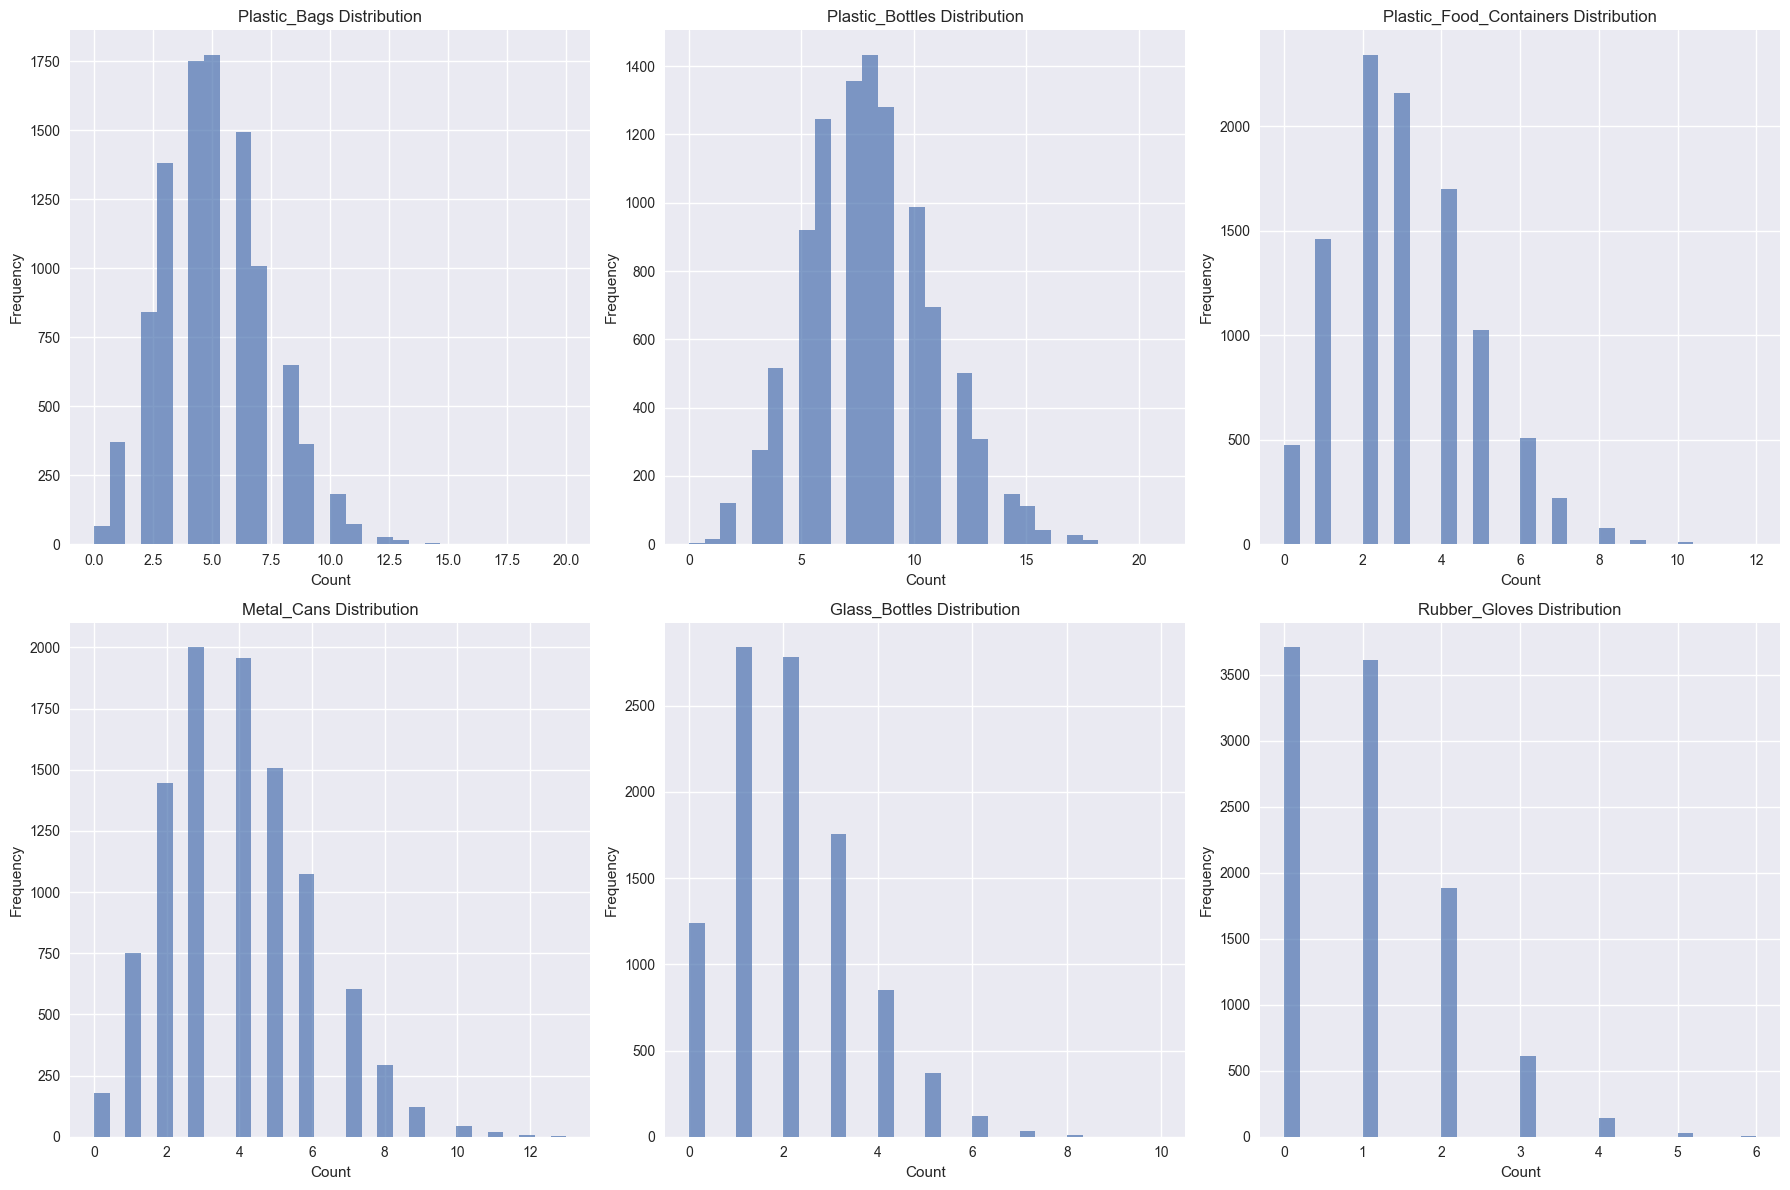

🗺️ Creating geographic analysis...
🗺️ Interactive map saved to: /Users/punnoosekthomas/Documents/Hobby Projects/marine-debris-classification/visualizations/debris_locations_map.html
📅 Creating temporal analysis...


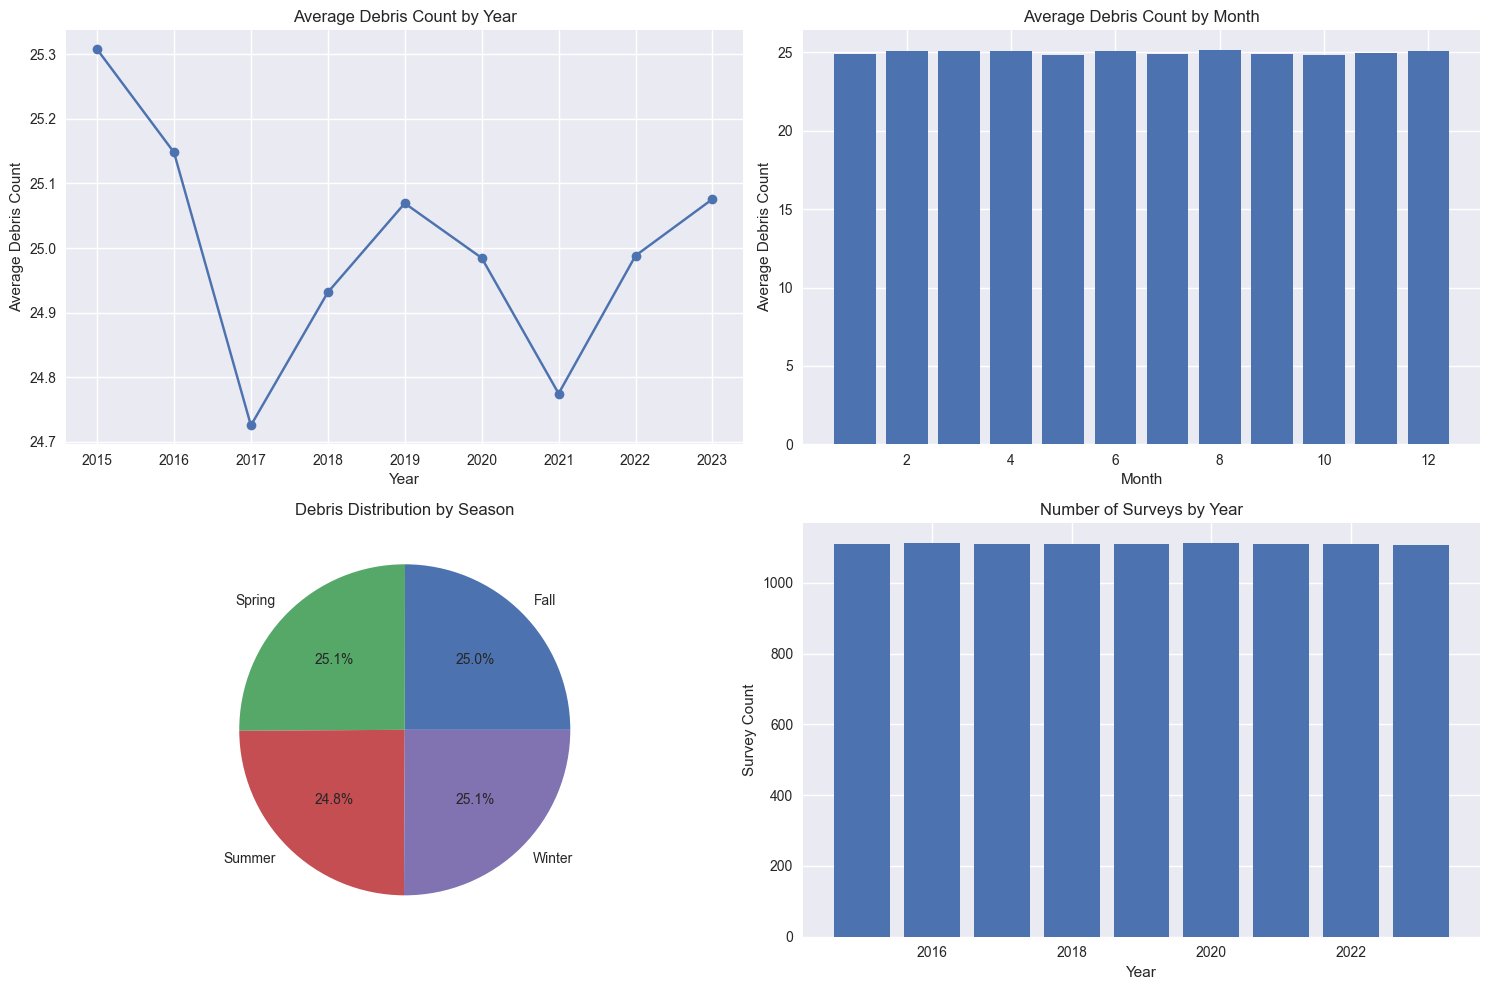

🗑️ Creating debris type analysis...


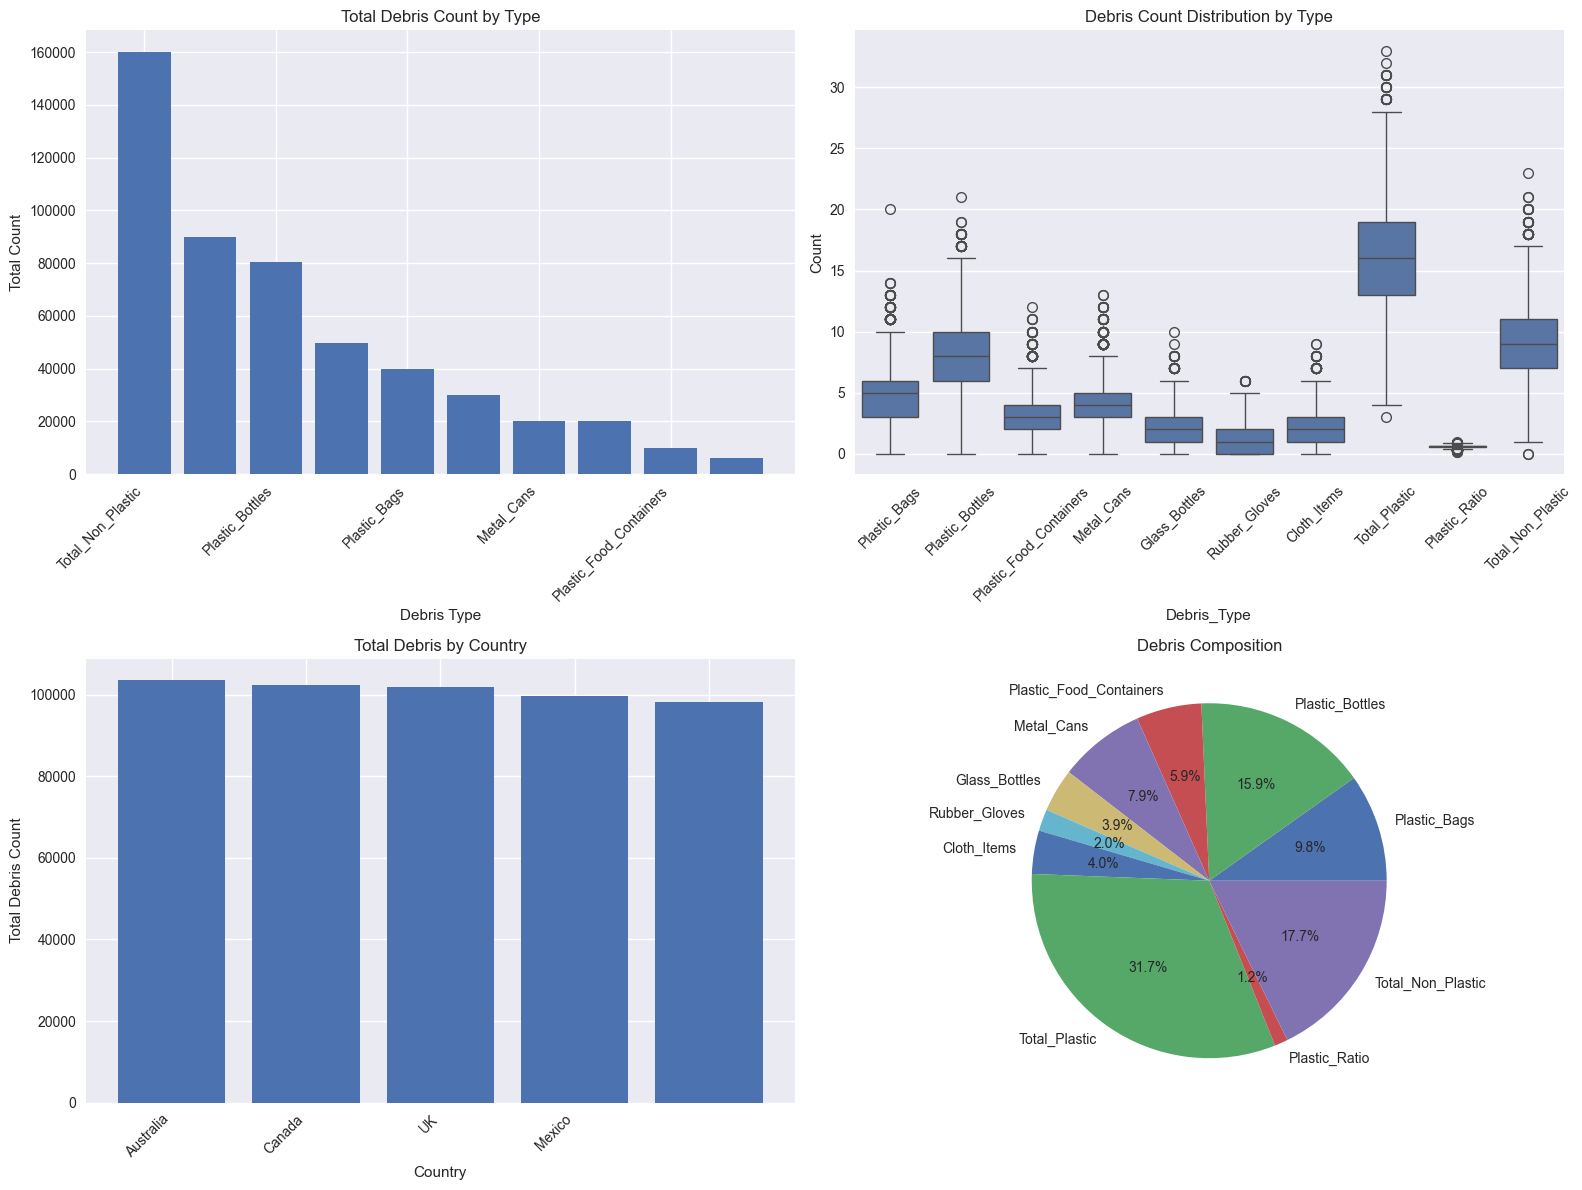

🌦️ Creating environmental analysis...


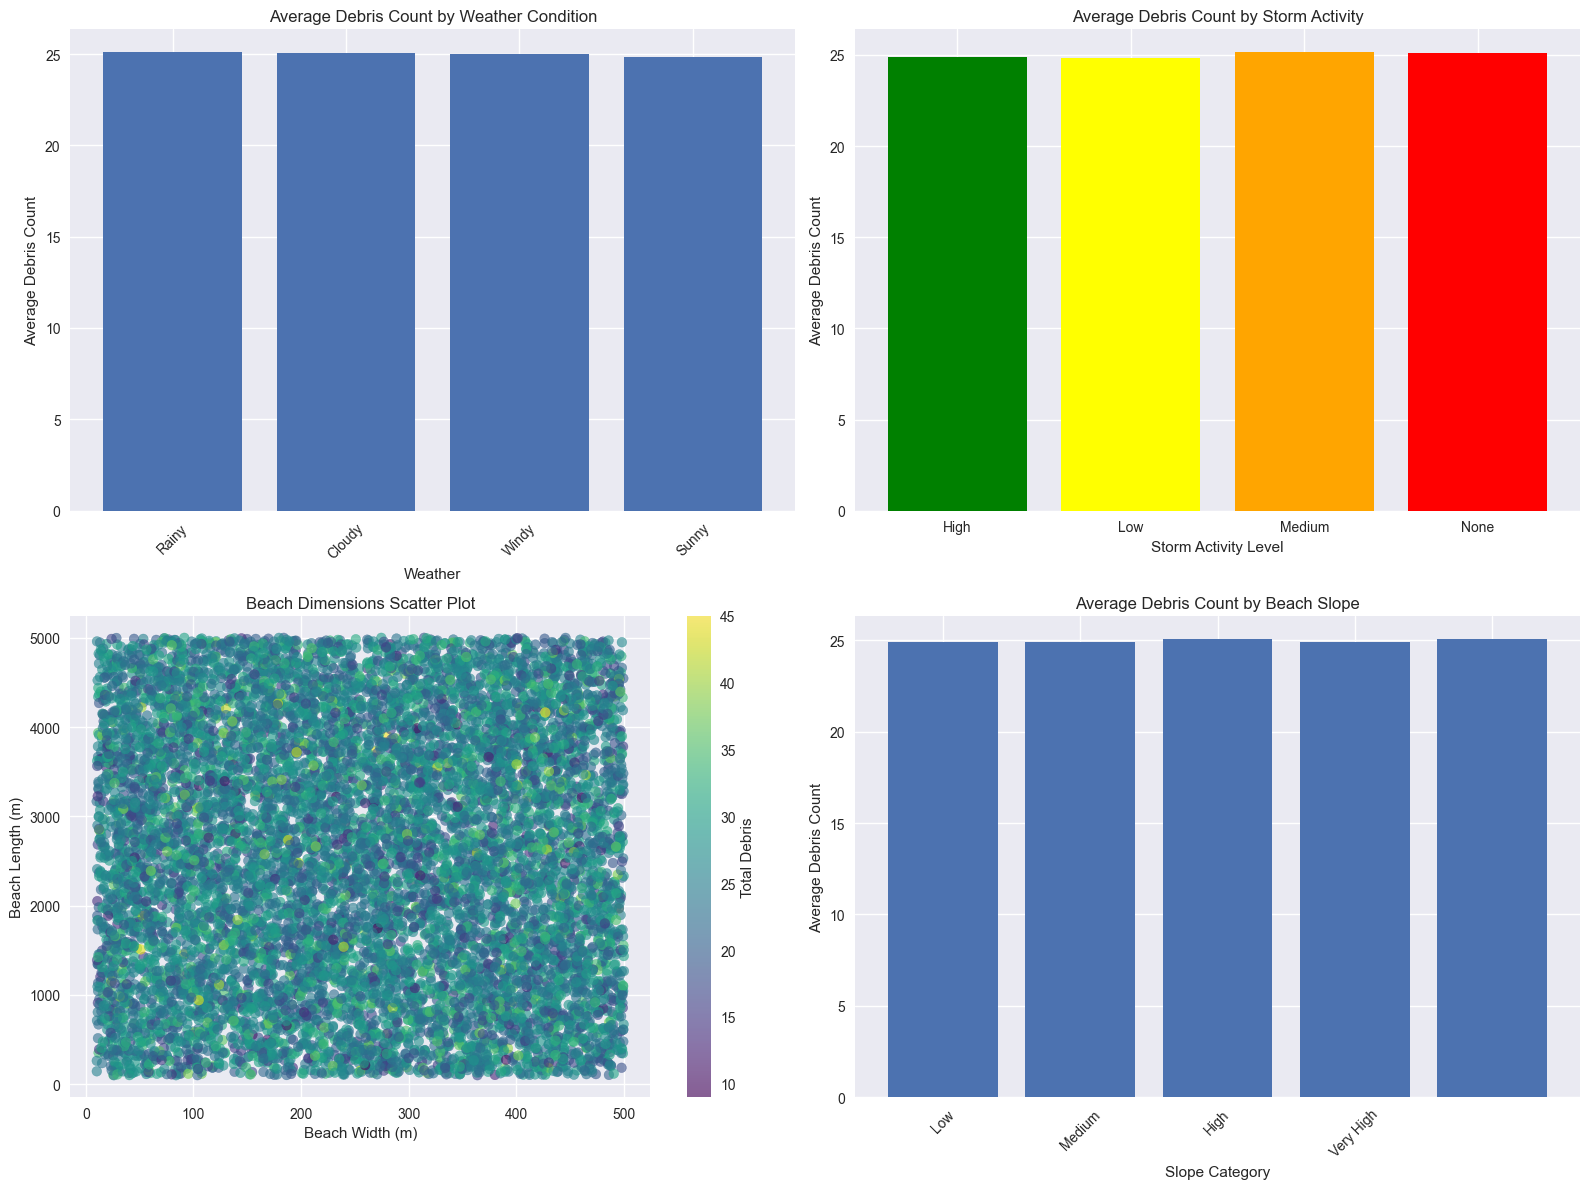

📊 Generating comprehensive metrics...
📊 Calculating comprehensive metrics...
✅ Metrics calculation completed!
💾 Saving metrics report...
📊 Metrics saved to: /Users/punnoosekthomas/Documents/Hobby Projects/marine-debris-classification/results/comprehensive_metrics.json
📋 Report saved to: /Users/punnoosekthomas/Documents/Hobby Projects/marine-debris-classification/results/metrics_report.md
🔗 Creating correlation analysis...
🔗 Creating correlation analysis...


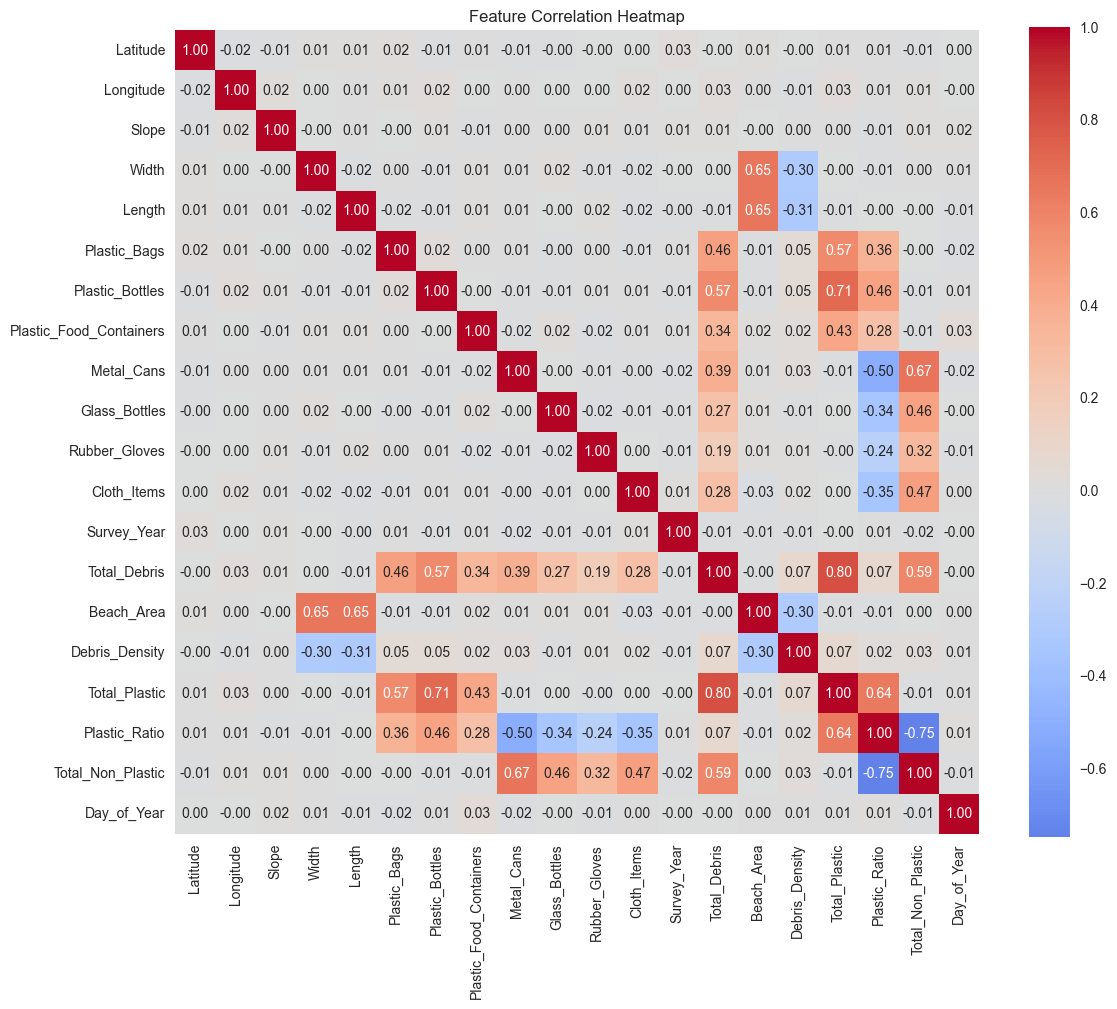


🤖 Starting Basic Model Training...
🚀 Training basic ML models...
🔧 Preparing data for modeling...
✅ Feature matrix shape: (10000, 40)
📋 Features: ['Latitude', 'Longitude', 'Slope', 'Width', 'Length', 'Plastic_Bags', 'Plastic_Bottles', 'Plastic_Food_Containers', 'Metal_Cans', 'Glass_Bottles']...
  🌲 Training Random Forest Classifier...
  🌲 Training Random Forest Regressor...
✅ Model training completed. Trained 2 models.
💾 Saving trained models...
  💾 rf_classifier saved to /Users/punnoosekthomas/Documents/Hobby Projects/marine-debris-classification/models/trained/rf_classifier.joblib
  💾 rf_regressor saved to /Users/punnoosekthomas/Documents/Hobby Projects/marine-debris-classification/models/trained/rf_regressor.joblib

📊 Generating Model Performance Metrics...
📊 Creating model evaluation visualizations...
  📈 Creating performance summary...


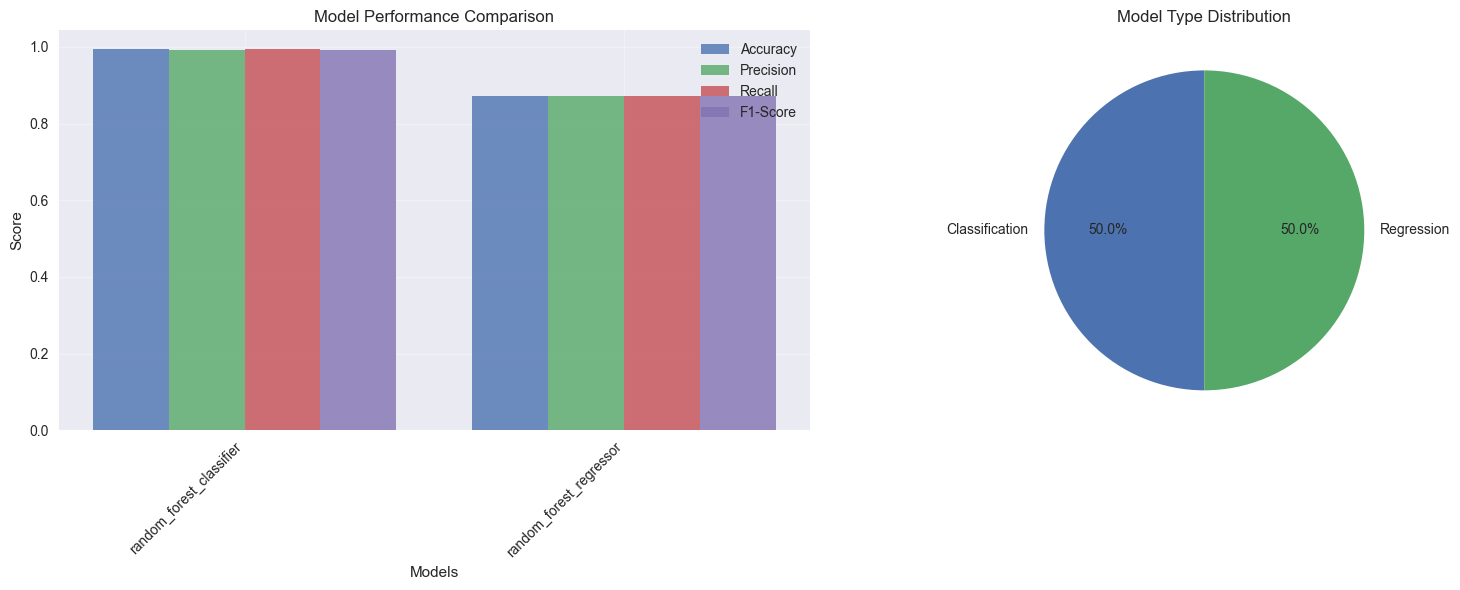

  📊 Performance summary saved to /Users/punnoosekthomas/Documents/Hobby Projects/marine-debris-classification/results/metrics
  🔄 Creating confusion matrices...


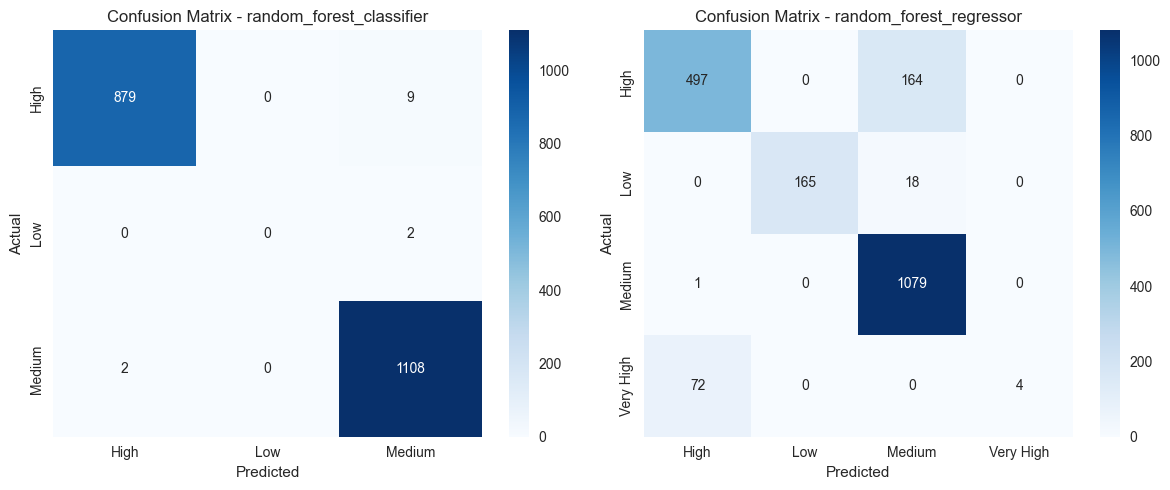

  🎯 Creating feature importance plots...


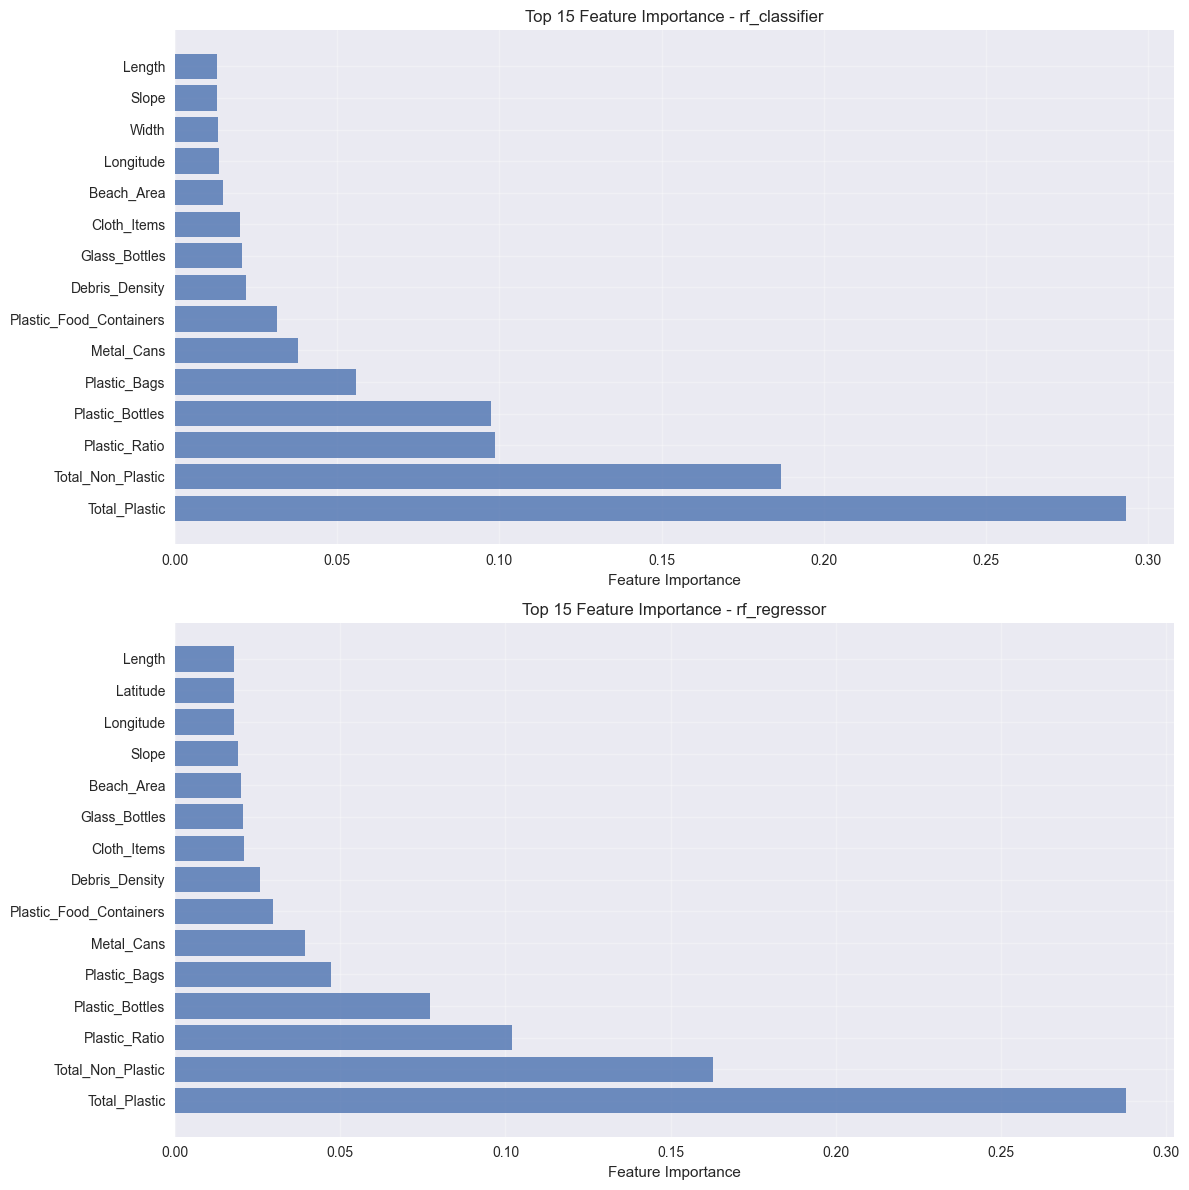

  📈 Creating ROC curves...
  📝 Saving training logs...
  📝 Training logs saved to /Users/punnoosekthomas/Documents/Hobby Projects/marine-debris-classification/results/metrics/training_logs.txt
  💾 Saving detailed metrics...
  💾 Detailed metrics saved to /Users/punnoosekthomas/Documents/Hobby Projects/marine-debris-classification/results/metrics/complete_training_results.json
✅ All model evaluations completed!
⚠️ Advanced ML features not available. Using basic models only.

📋 Creating Summary Report...
📋 Summary report saved to: /Users/punnoosekthomas/Documents/Hobby Projects/marine-debris-classification/reports/marine_debris_analysis_report.md


In [45]:
print("🌊 Marine Debris Source Classification Project")
print("=" * 50)

# Initialize data loader
loader = MarineDebrisDataLoader(DATASET_CONFIG)

# Load data
data = loader.load_raw_data()

if data is not None:
    print(f"✅ Data loaded successfully: {data.shape}")
    print(f"📊 Columns: {list(data.columns)}")
    
    # Initialize preprocessor
    preprocessor = MarineDebrisPreprocessor(data)
    
    # Basic preprocessing
    processed_data = preprocessor.basic_preprocessing()
    print(f"✅ Basic preprocessing completed: {processed_data.shape}")
    
    # Save processed data
    processed_file = PROCESSED_DATA_DIR / 'marine_debris_processed.csv'
    processed_data.to_csv(processed_file, index=False)
    print(f"💾 Processed data saved to: {processed_file}")
    
    # Enhanced Data Analysis and Visualization
    print("\n📊 Starting Data Analysis and Visualization...")
    
    # Create enhanced features for visualization
    analysis_data = create_analysis_features(processed_data)
    
    # Always create basic visualizations
    print("📈 Creating visualizations and metrics...")
    visualizer = MarineDebrisVisualizer(analysis_data)
    visualizer.create_distribution_plots()
    visualizer.create_geographic_analysis()
    visualizer.create_temporal_analysis()
    visualizer.create_debris_analysis()
    visualizer.create_environmental_analysis()
    
    # Generate comprehensive metrics
    print("📊 Generating comprehensive metrics...")
    metrics = generate_comprehensive_metrics(analysis_data)
    save_metrics_report(metrics)
    
    # Basic correlation analysis (always available)
    print("🔗 Creating correlation analysis...")
    analytics = MarineDebrisAnalytics(analysis_data, {})
    analytics.create_correlation_analysis()
    
    # Basic Model Training (always available with scikit-learn)
    print("\n🤖 Starting Basic Model Training...")
    basic_trainer = BasicModelTrainer(analysis_data)
    models, training_results = basic_trainer.train_basic_models()
    basic_trainer.save_models(TRAINED_MODELS_DIR)
    
    # Generate Model Performance Metrics and Visualizations
    print("\n📊 Generating Model Performance Metrics...")
    model_evaluator = ModelPerformanceEvaluator(analysis_data, models, training_results)
    model_evaluator.create_all_evaluations()
    
    # Feature Engineering and Advanced Models (if available)
    engineered_data = analysis_data
    try:
        from marine_debris_models import MarineDebrisFeatureEngineer, MarineDebrisModelTrainer
        
        print("\n🔧 Starting Advanced Feature Engineering...")
        engineer = MarineDebrisFeatureEngineer(processed_data)
        engineered_data = engineer.engineer_all_features()
        
        # Save engineered data
        engineered_file = PROCESSED_DATA_DIR / 'marine_debris_engineered.csv'
        engineered_data.to_csv(engineered_file, index=False)
        print(f"💾 Engineered data saved to: {engineered_file}")
        
        # Advanced Model Training
        print("\n🤖 Starting Advanced Model Training...")
        trainer = MarineDebrisModelTrainer(engineered_data)
        trainer.train_all_models()
        trainer.save_models(TRAINED_MODELS_DIR)
        
        # Advanced Analytics with trained models
        print("\n🔍 Running Advanced Analytics...")
        analytics = MarineDebrisAnalytics(engineered_data, trainer.models)
        analytics.analyze_feature_importance()
        
    except ImportError:
        print("⚠️ Advanced ML features not available. Using basic models only.")
        
    # Create summary report
    print("\n📋 Creating Summary Report...")
    create_summary_report(engineered_data)
    
else:
    print("❌ Failed to load data")

In [46]:
# Full Marine Debris Analysis - Step by Step Execution
print("🌊 Marine Debris Source Classification Project - Jupyter Notebook")
print("=" * 60)

# Step 1: Initialize and Load Data
print("\n🔄 Step 1: Data Loading and Initialization")
loader = MarineDebrisDataLoader(DATASET_CONFIG)
data = loader.load_raw_data()

if data is not None:
    print(f"✅ Data loaded successfully: {data.shape}")
    print(f"📊 Columns: {list(data.columns)}")
    
    # Step 2: Data Preprocessing
    print("\n🔄 Step 2: Data Preprocessing")
    preprocessor = MarineDebrisPreprocessor(data)
    processed_data = preprocessor.basic_preprocessing()
    print(f"✅ Basic preprocessing completed: {processed_data.shape}")
    
    # Save processed data
    processed_file = PROCESSED_DATA_DIR / 'marine_debris_processed.csv'
    processed_data.to_csv(processed_file, index=False)
    print(f"💾 Processed data saved to: {processed_file}")
    
    # Step 3: Feature Engineering
    print("\n🔄 Step 3: Feature Engineering for Analysis")
    analysis_data = create_analysis_features(processed_data)
    print(f"✅ Enhanced features created: {analysis_data.shape}")
    
    # Display key features created
    if 'Total_Debris' in analysis_data.columns:
        print(f"📈 Total debris statistics:")
        print(f"   - Mean: {analysis_data['Total_Debris'].mean():.2f}")
        print(f"   - Max: {analysis_data['Total_Debris'].max()}")
        print(f"   - Total collected: {analysis_data['Total_Debris'].sum():,}")
    
    print("\\n🎯 Setup complete! Ready for visualization and modeling steps.")
    print("   Next: Run visualization cells and model training cells individually")
    
else:
    print("❌ Failed to load data. Please check the data source.")


2025-06-12 13:00:16,073 - __main__ - INFO - Loading data from: /Users/punnoosekthomas/Documents/Hobby Projects/marine-debris-classification/data/raw/nasaa.csv
2025-06-12 13:00:16,073 - __main__ - ERROR - Data file not found: /Users/punnoosekthomas/Documents/Hobby Projects/marine-debris-classification/data/raw/nasaa.csv
2025-06-12 13:00:16,074 - __main__ - INFO - Creating sample marine debris data...
2025-06-12 13:00:16,124 - __main__ - INFO - Sample data created and saved to: /Users/punnoosekthomas/Documents/Hobby Projects/marine-debris-classification/data/raw/sample_marine_debris.csv
2025-06-12 13:00:16,126 - __main__ - INFO - Starting basic preprocessing...
2025-06-12 13:00:16,127 - __main__ - INFO - Handling missing values...
2025-06-12 13:00:16,129 - __main__ - INFO - Converting data types...
2025-06-12 13:00:16,134 - __main__ - INFO - Removing outliers...
2025-06-12 13:00:16,138 - __main__ - INFO - Basic preprocessing completed. Shape: (10000, 21)


🌊 Marine Debris Source Classification Project - Jupyter Notebook

🔄 Step 1: Data Loading and Initialization
✅ Data loaded successfully: (10000, 21)
📊 Columns: ['Country', 'State', 'Latitude', 'Longitude', 'Date', 'Season', 'Weather', 'Storm_Activity', 'Slope', 'Width', 'Length', 'Plastic_Bags', 'Plastic_Bottles', 'Plastic_Food_Containers', 'Metal_Cans', 'Glass_Bottles', 'Rubber_Gloves', 'Cloth_Items', 'Organization', 'Shoreline_Name', 'Survey_Year']

🔄 Step 2: Data Preprocessing
✅ Basic preprocessing completed: (10000, 21)
💾 Processed data saved to: /Users/punnoosekthomas/Documents/Hobby Projects/marine-debris-classification/data/processed/marine_debris_processed.csv

🔄 Step 3: Feature Engineering for Analysis
🔧 Creating analysis features...
✅ Enhanced data shape: (10000, 31)
✅ Enhanced features created: (10000, 31)
📈 Total debris statistics:
   - Mean: 25.00
   - Max: 45
   - Total collected: 250,007
\n🎯 Setup complete! Ready for visualization and modeling steps.
   Next: Run visualiz